In [1]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt

# Optimal control computation

> Let's try to find the optimal trajectory of the rat using the optimal control theory. A simple plant equation can be chosen as:

$$\dot{x}(t)=u(t) + v_t$$

> $\dot{x}$ is the displacement of the rat in the frame of the laboratory. $u(t)$, the velocity of the rat in its frame of reference, is the control parameter. If we assume that the rats can only run against the treadmill, then $u(t) \leq 0 \ \forall \  t$. If the absolute velocity $|u|$ of the rat is equal to that of the treadmill, the displacement in the frame of the laboratory is null. If $|u| > v_t$ then there is a negative displacement, from the right to the left, the rat moves towards the beginning of the treadmill. We can add the following constraints: $|u|\leq 0.7$ m.s$^{-1}$, $x(t) \in [0,L_T] \ \forall \ t$.

> Let's assume that the physical cost can be written as follows:

$$J(u,\alpha) = \int_{0}^{T} \left(a+b u(t)^\alpha \right)dt$$

> We will consider two different kinds of cost; $J(u,1)$ (affine cost) and $J(u,2)$ (quadratic cost).

> The general problem that we have to solve is as follows:

$$\min_{\substack{ x \in [0,T]\times \mathbb{R}^N_x \\ u \in [0,T]\times \mathbb{R}^N_u}} \int_0^T L(t,x(t),u(t)) dt + E(T,x(T))$$

$$\begin{cases}
\dot{x}=f(t,x(t),u(t))\\
\underline{x}_0 \leq x(0) \leq \overline{x}_0   \\
\underline{x}_f \leq x(T) \leq \overline{x}_f   \\
\underline{x} \leq x(t) \leq \overline{x}   \\
\underline{u} \leq u(t) \leq \overline{u}   \\
t \in [0,T]
\end{cases}$$

> Our problem can be simplified to:

$$\min_{\substack{ x \in [0,7]\times \mathbb{R}^N_x \\ u \in [0,7]\times \mathbb{R}^N_u}}  \int_{0}^{7} \left(a+b u(t)^\alpha \right)$$

$$\begin{cases}
\dot{x}=u+v_t\\
x(0) = x_0   \\
x(T) = x_f  \\
0 \leq x(t) \leq L_{tread}   \\
-0.7 \leq u(t) \leq 0.0   \\
t \in [0,7]
\end{cases}$$

with $L_{tread}=0.9$ m the length of the treadmill. We will use the program CasADi, using a collation numerical method, to perform this computation.

In [33]:
def optimal_trajectory(cost,a,b,x0,xf,tf):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    vtapis=0.1
    Ltread=0.9
    nk = 100    # Control discretization

    # Declare variables (use scalar graph)
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  vdp oscillator states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(vtapis + u, 0.0)
    if cost=='linear':  #Choose between linear and quadratic power law
        rhs["L"] = (a+b*fabs(u))
    elif cost=='quadratic':
        rhs["L"] = a+b*u*u
        
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7
    u_max = 0.0
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   0.0, -inf]
    x_max =  [Ltread,0.0,  inf]
    xi_min = [x0,  0.0,  0.0]
    xi_max = [x0,  0.0,  0.0]
    xf_min = [xf,  0.0, -inf]
    xf_max = [xf,  0.0,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)

    return(x0_opt,tgrid,u_opt,tgrid_u)



## Linear cost

> Firstly, let's compute the optimal trajectory minimizing a power law linear with respect to the velocity of the rat. Heglund, Cavagna & Taylor (1981) derived an average power law valid for all mammals (the mass of the rat is taken to be $m=0.3$ kg): 

$$\dot{E} = 0.2055 v_g + 0.0216$$


In [34]:
x0_opt,tgrid,u_opt,tgrid_u = optimal_trajectory(cost='linear',a=0.0216,b=0.2055,x0=0.0,xf=0.0,tf=7.0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Too few degrees of freedom (n_x = 905, n_c = 1200).
  Trying fixed_variable_treatment = RELAX_BOUNDS

Number of nonzeros in equality constraint Jacobian...:     4800
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:     1312
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      909
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bou

CasADi -  WARNING("NLP is overconstrained: There are 1607 equality constraints but only 1312 variables.") [.../casadi/core/nlpsol.cpp:492]


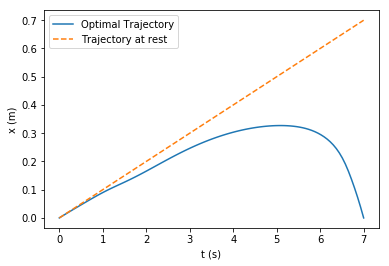

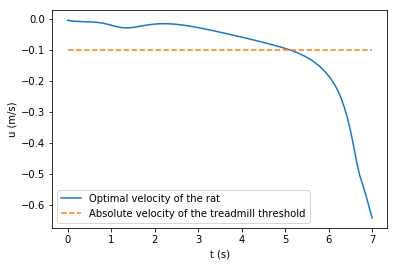

In [35]:
plt.plot(tgrid,x0_opt,label='Optimal Trajectory')
plt.plot(tgrid,[0.1*t for t in tgrid],'--',label='Trajectory at rest')
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

plt.plot(tgrid_u,u_opt,label='Optimal velocity of the rat')
plt.plot(tgrid_u,[-0.1 for t in tgrid_u],'--',label='Absolute velocity of the treadmill threshold')
plt.ylabel('u (m/s)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

### Discussion

To be completed.

## Quadratic cost

In his 1958 paper, Ralston derived the following power law for people performing a walking task:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

In [42]:
x0_opt,tgrid,u_opt,tgrid_u = optimal_trajectory(cost='quadratic',a=0.61,b=1.109E-04,x0=0.0,xf=0.0,tf=7.0)

CasADi -  WARNING("NLP is overconstrained: There are 1607 equality constraints but only 1312 variables.") [.../casadi/core/nlpsol.cpp:492]


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Too few degrees of freedom (n_x = 905, n_c = 1200).
  Trying fixed_variable_treatment = RELAX_BOUNDS

Number of nonzeros in equality constraint Jacobian...:     4800
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:     1312
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      909
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bou

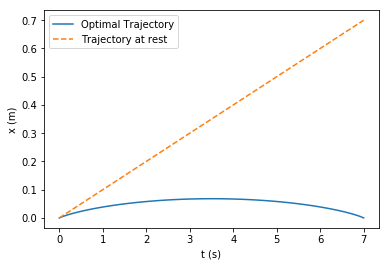

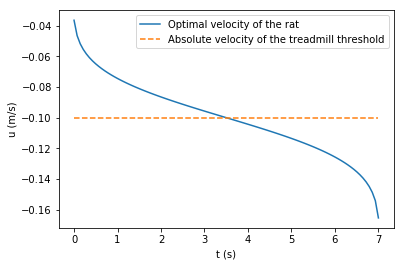

In [43]:
plt.plot(tgrid,x0_opt,label='Optimal Trajectory')
plt.plot(tgrid,[0.1*t for t in tgrid],'--',label='Trajectory at rest')
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

plt.plot(tgrid_u,u_opt,label='Optimal velocity of the rat')
plt.plot(tgrid_u,[-0.1 for t in tgrid_u],'--',label='Absolute velocity of the treadmill threshold')
plt.ylabel('u (m/s)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

### Discussion

> This model for the cost yields a very unrealistic trajectory for the rat. We can assume that in this range of velocities, the quadratic power law is not adapted. To be completed...
 